# Hands On Machine Learning: Chapter 3, Exercise 3

## Titanic Survival

### Project Checklist:

1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to ML-Learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution (skip for this exercise)
8. Launch, monitor, and maitain your system (skip for this exercise).

#### 1. Frame the problem / look at the big picture

- Objective: predict survival / not-survival of passenger
- Solution used by feeding it a new passenger
- Current solution? (N/A)
- This is a supervised, offline learning problem.
- Performance should be classification rate, precision, recall, F1 score.

#### 2. Get the data

In [132]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [183]:
train = pd.read_csv('datasets/titanic/train.csv')
test = pd.read_csv('datasets/titanic/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train['Survived'] = train['Survived'].astype('category')
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [184]:
train['Pclass'] = train['Pclass'].astype('category')
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

#### Explore the data to gain insights

In [185]:
train.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Who is the Parch outlier? I assume she had 6 kids?
train[train['Parch']==6].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S


In [7]:
# Who has to Fare outlier?
train[train['Fare'] > 500].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null category
Pclass         891 non-null category
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: category(2), float64(2), int64(3), object(5)
memory usage: 71.6+ KB


In [9]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

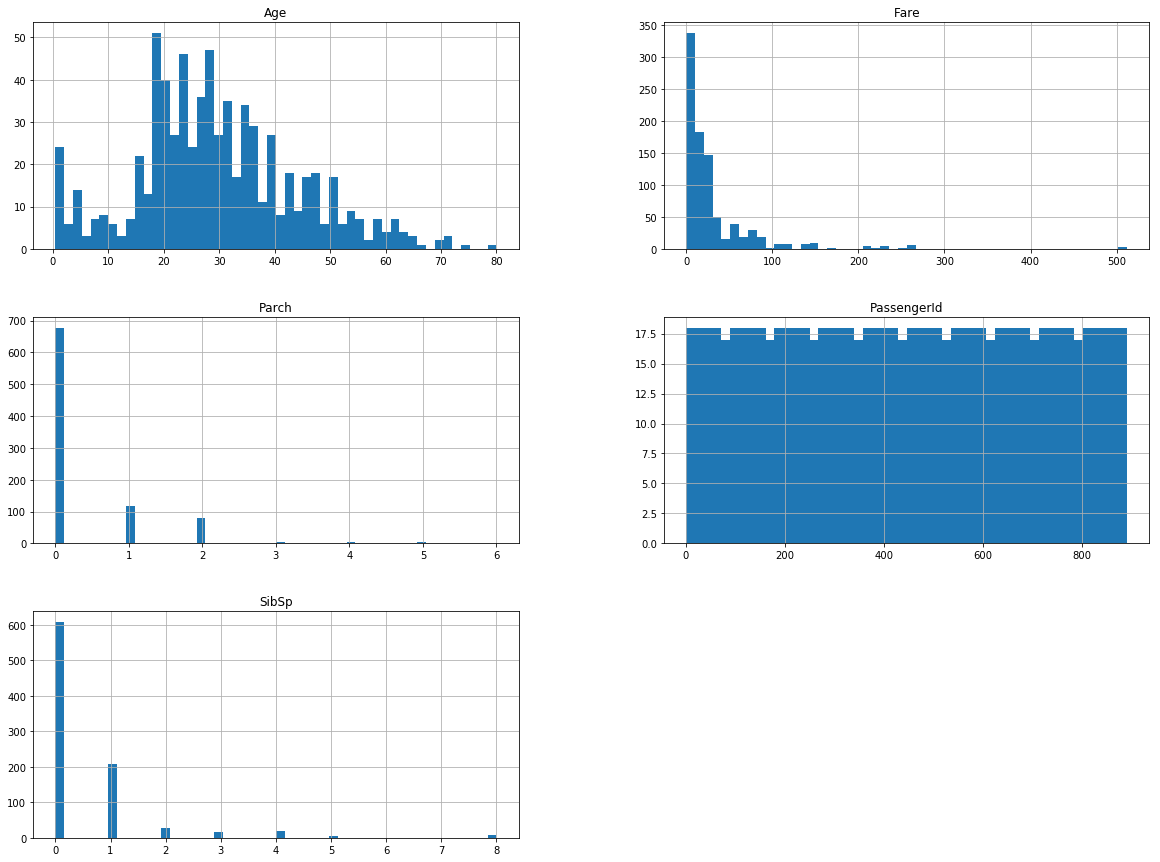

In [11]:
train.hist(bins=50, figsize=(20,15));

Basic hypothesis: Rich people had a better chance of survival?

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


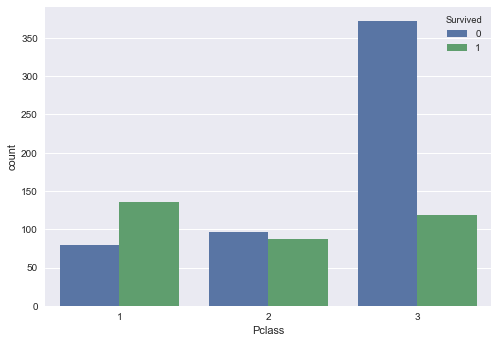

In [276]:
sns.countplot(x='Pclass', hue='Survived', data=train);

It does seem that people in 3rd class (poor people) fared much worse.

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


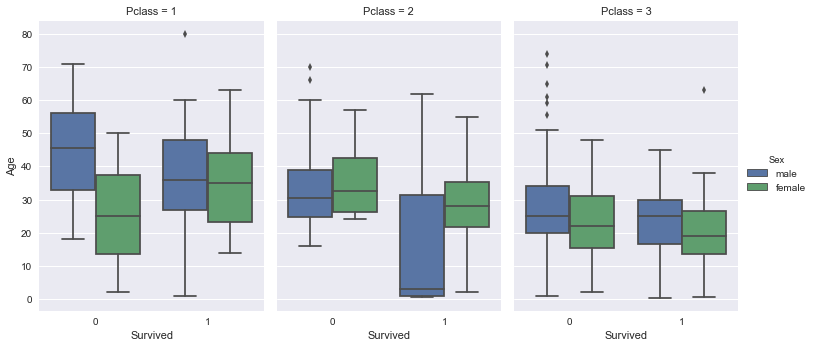

In [273]:
sns.factorplot(x="Survived", y="Age", hue="Sex",
               col="Pclass", data=train, kind="box", size=5, aspect=.7);

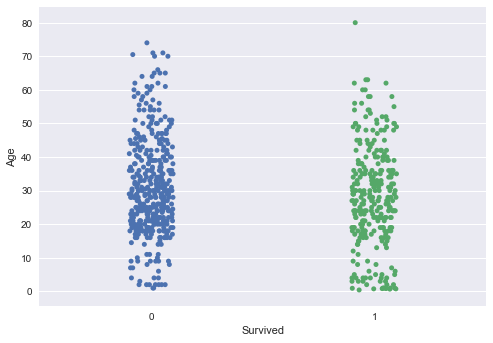

In [135]:
sns.stripplot(x='Survived', y='Age', data=train, jitter=True);

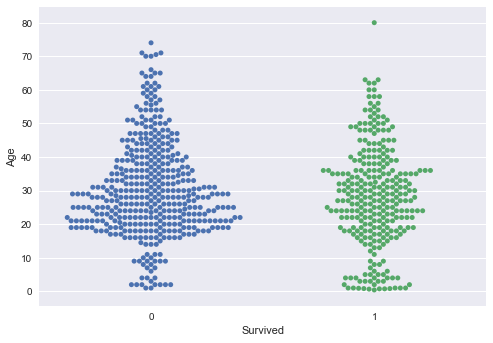

In [137]:
sns.swarmplot(x='Survived', y='Age', data=train);

In [23]:
# how many unique names across the training set?
len(train['Name'].unique())

891

It doesn't appear that there are any duplicates in the training data.  However, titles seem to be included in the Name variable.

Let's look a little closer at some of these titles.

In [186]:
# "Miss."
#print(train['Name'])
misses = train[['Miss.' in name for name in train['Name']]]
misses.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q


In [187]:
# "Mrs."
mrses = train[['Mrs.' in name for name in train['Name']]]
mrses.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
15,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S


Hypothesis: Titles correlate with Age.

In [188]:
# Mr.
males = train[train['Sex'] == 'male']
males.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [189]:
# create utility function to extract title from Name
def extractTitle(name):
    #names = X['Name']
    #print(name)
    if ('Miss.' in name):
        return 'Miss.'
    elif ('Mrs.' in name):
        return 'Mrs.'
    elif ('Master.' in name):
        return 'Master'
    elif ('Mr.' in name):
        return 'Mr.'
    else:
        return 'Other'

In [190]:
titles = train['Name'].apply(extractTitle)
train = train.assign(Title = pd.Series(titles, index=train.index))
train['Title'] = train['Title'].astype('category')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


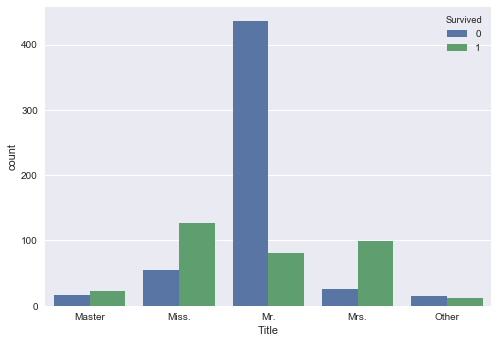

In [272]:
# Let's check survival rates across titles
sns.countplot(x='Title', data= train, hue='Survived');

In [101]:
# What's the distribution of females to males across the training set?
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [102]:
train['Title'].value_counts()

Mr.       517
Miss.     182
Mrs.      125
Master     40
Other      27
Name: Title, dtype: int64

Pclass  Sex     Survived
1       female  0             3
                1            91
        male    0            77
                1            45
2       female  0             6
                1            70
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64


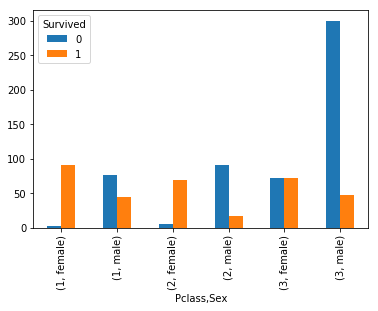

In [104]:
ag = train.groupby(['Pclass', 'Sex']).Survived.value_counts().sort_index()
print(ag)
#ag.plot(kind='bar')
ag.unstack().plot(kind='bar');
#train['Pclass'].plot(kind='bar', figsize=(10,8))

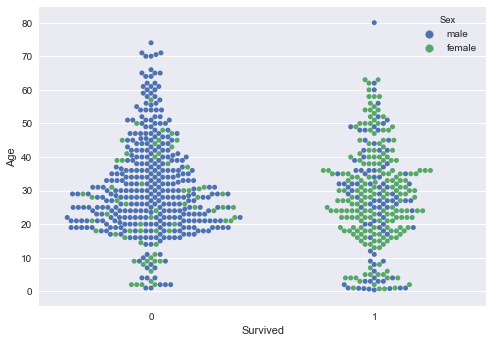

In [141]:
sns.swarmplot(x='Survived', y='Age', data=train, hue='Sex');

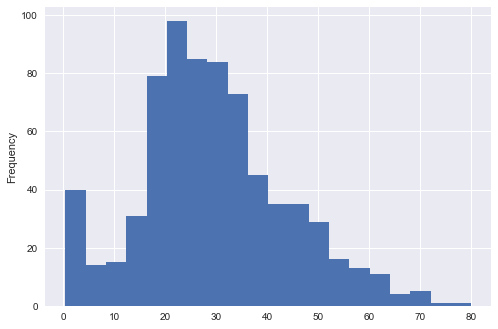

In [142]:
# plot age distribution over training set
train['Age'].plot(kind='hist',  bins=20);

How do I plot separate 'Age' histograms across 'Pclass'?

In [114]:
# check if the title 'Master' is a good proxy for young boys
boys = train.loc[train['Title'] == 'Master']
boys['Age'].describe()

count    36.000000
mean      4.574167
std       3.619872
min       0.420000
25%       1.000000
50%       3.500000
75%       8.000000
max      12.000000
Name: Age, dtype: float64

In [115]:
# Miss is more complicated I think.
misses['Age'].describe()

count    146.000000
mean      21.773973
std       12.990292
min        0.750000
25%       14.125000
50%       21.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64

In [126]:
misses_alone = misses[(misses.SibSp == 0) & (misses.Parch == 0)]
print(misses_alone.describe())
"Number of girls traveling along younger than 14.5: {}".format(len(misses[misses.Age < 14.5]))

       PassengerId        Age  SibSp  Parch        Fare
count    100.00000  78.000000  100.0  100.0  100.000000
mean     400.61000  27.743590    0.0    0.0   38.287835
std      246.12598  10.410018    0.0    0.0   69.696931
min        3.00000   5.000000    0.0    0.0    6.750000
25%      215.75000  21.000000    0.0    0.0    7.750000
50%      358.50000  26.000000    0.0    0.0    9.839600
75%      600.25000  33.625000    0.0    0.0   27.090625
max      888.00000  58.000000    0.0    0.0  512.329200


'Number of girls traveling along younger than 14.5: 37'

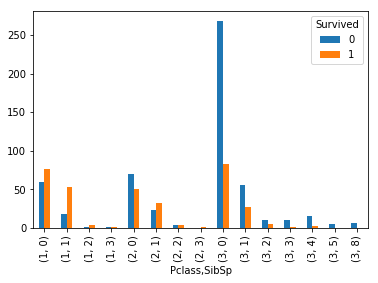

In [131]:
# check out Sibsp and Parch
ag = train.groupby(['Pclass', 'SibSp']).Survived.value_counts().sort_index()
#print(ag)
#ag.plot(kind='bar')
ag.unstack().plot(kind='bar');
#train['Pclass'].plot(kind='bar', figsize=(10,8))

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


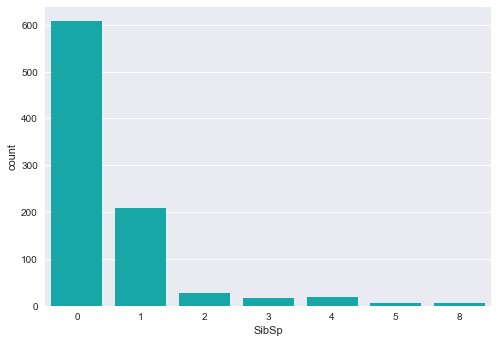

In [154]:
sns.countplot(data=train, x='SibSp', color='c');

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


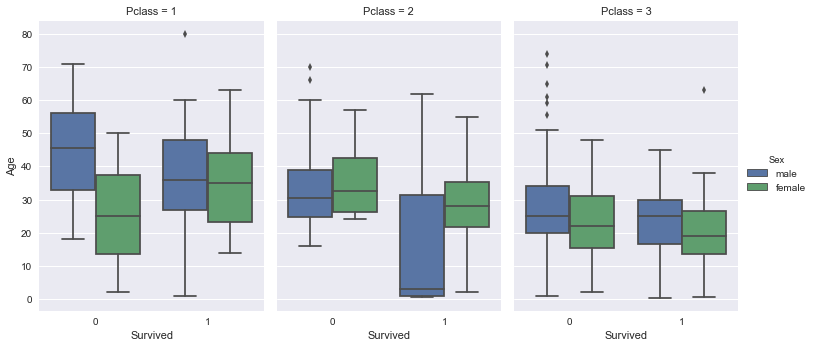

In [149]:
sns.factorplot(x="Survived", y="Age", hue="Sex",
               col="Pclass", data=train, kind="box", size=5, aspect=.7);

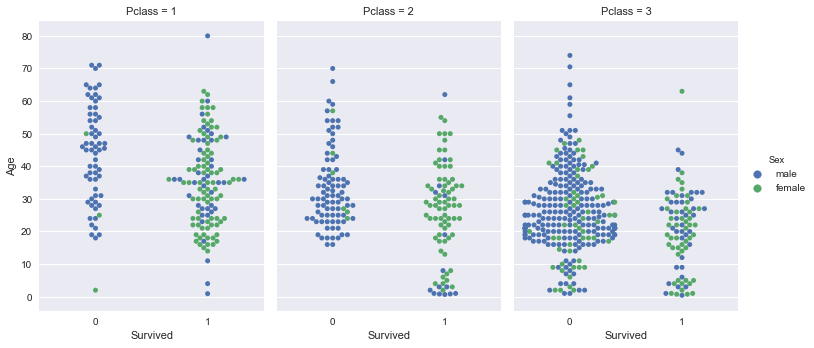

In [150]:
sns.factorplot(x="Survived", y="Age", hue="Sex",
               col="Pclass", data=train, kind="swarm", size=5, aspect=.7);

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


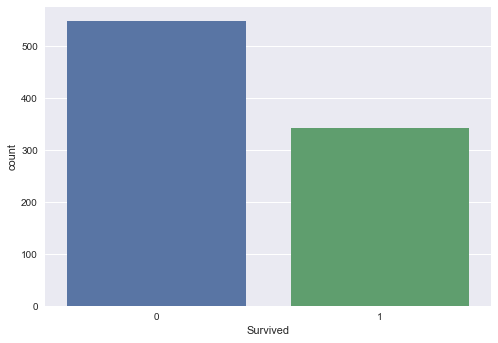

In [157]:
sns.countplot(x="Survived", data=train);

In [191]:
# look at Cabin a bit
len(train[train['Cabin'].isna()])

687

In [202]:
#train['Cabin'].isna()
idxs = train['Cabin'].isna()
print(type(train['Cabin']))

<class 'pandas.core.series.Series'>


In [208]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,nan,S,Mr.,n
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S,Miss.,n
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,nan,S,Mr.,n


In [213]:
def extractDeck(cabin):
    if cabin.upper() == "NAN":
        return "U"
    else:
        return cabin[0]

In [214]:
if ('Deck' in train.columns):
    train.drop(['Deck'], axis=1)
train['Cabin'] = train['Cabin'].astype('str')
decks = train['Cabin'].apply(extractDeck)
train = train.assign(Deck = pd.Series(decks, index=train.index))
train['Deck'] = train['Deck'].astype('category')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,nan,S,Mr.,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S,Miss.,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,nan,S,Mr.,U


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


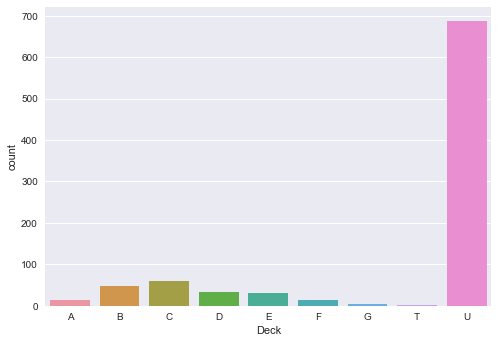

In [217]:
sns.countplot(x='Deck', data=train);

In [218]:
# family size
temp_Sibsp = train['SibSp']
temp_Parch = train['Parch']
familysize = temp_Sibsp + temp_Parch + 1
train = train.assign(FamilySize = pd.Series(familysize, index=train.index))
train['FamilySize'] = train['FamilySize'].astype('category')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,nan,S,Mr.,U,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S,Miss.,U,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,nan,S,Mr.,U,1


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


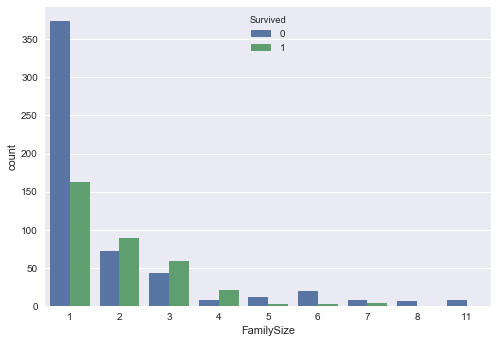

In [222]:
sns.countplot(data=train, x='FamilySize', hue='Survived');

### Exploratory Modeling

In [262]:
# import sklearn RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score

labelencoder = LabelEncoder()
onehotencoder = OneHotEncoder()
forest_clf = RandomForestClassifier(random_state=42, n_estimators=1000)

In [263]:
train_X = train.loc[:, ['Pclass', 'Title']]
train_X_le = train_X.apply(labelencoder.fit_transform)
train_X_onehot = onehotencoder.fit_transform(train_X_le)
train_y = np.asarray(train.loc[:, ['Survived']]).ravel()
print(train_y.shape)
print(train_X_onehot.shape)

(891,)
(891, 8)


In [264]:
y_probas_forest = cross_val_predict(forest_clf, train_X_onehot, train_y, cv = 10, method="predict_proba")

In [265]:
y_scores_forest = y_probas_forest[:,1] # score = probability of positive class (5)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_y, y_scores_forest)

In [260]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

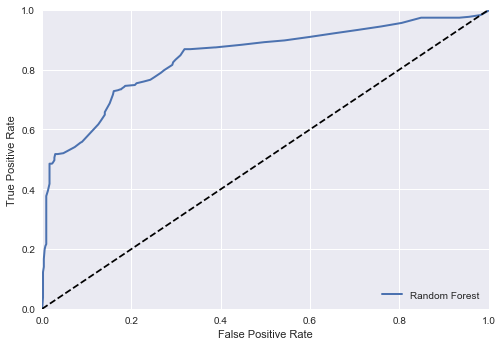

In [266]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

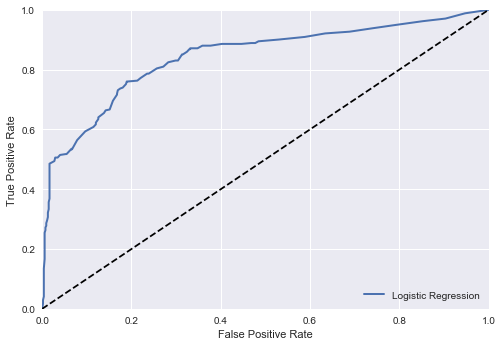

In [270]:
# try logistic regression?
from sklearn.linear_model import LogisticRegression

logReg_clf = LogisticRegression(penalty='l1', solver='saga', tol=0.1)
y_probas_logReg = cross_val_predict(logReg_clf, train_X_onehot, train_y, cv = 10, method="predict_proba")
y_scores_logReg = y_probas_logReg[:,1] # score = probability of positive class (5)
fpr_logReg, tpr_logReg, thresholds_logReg = roc_curve(train_y, y_scores_logReg)
plot_roc_curve(fpr_logReg, tpr_logReg, "Logistic Regression")
plt.legend(loc="lower right")
plt.show()